# setup

In [1]:
import os
os.chdir('/Users/martinmarek/Google Drive/bnn-regression')

# imports

In [2]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
import pickle

# relative imports
from core import models, distributions, datasets, utils, metrics
from core.sgd import train_sgd, train_ensamble
from core.rwmh import rwmh_sampler
from core.hmc import hmc_sampler
from core.nuts import nuts_sampler

/Users/martinmarek/miniforge3/envs/py39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

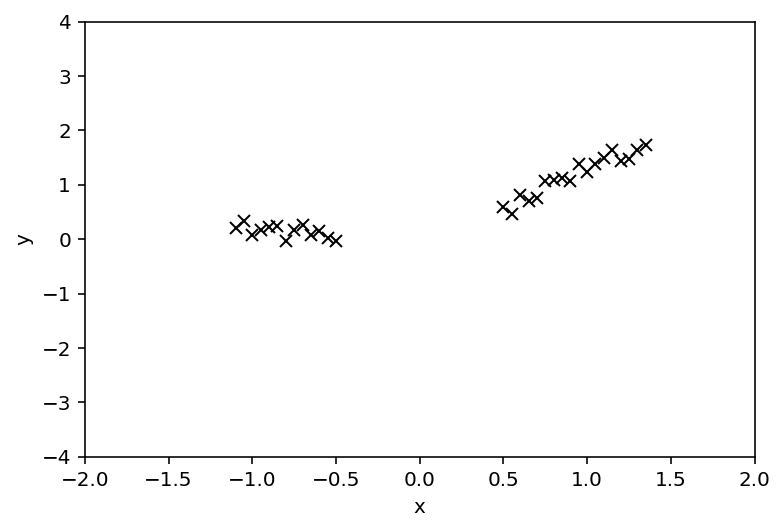

In [4]:
(x_true, y_true), (x_train, y_train), (x_test, y_test) = datasets.load_1d_regression_dataset()
fig, ax = plt.subplots()
# ax.plot(x_true[:, 0], y_true, label='true')
# ax.plot(x_test[:, 0], y_test, 'x', c='red', alpha=0.2, label='measured')
ax.plot(x_train[:, 0], y_train, 'x', c='black', label='measured')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])
# ax.legend()
plt.savefig('plots/1d_dataset.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# model

In [5]:
# define model
key = jax.random.PRNGKey(0)
layer_dims = 1*[50]
prior_sd = 1
init_sd = 0.1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
n_params = len(params_init)
params_init = init_sd*jax.random.normal(key, [n_params])
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior_fn(x_train, y_train, log_likelihood_fn, log_prior_fn)

In [6]:
# test model
print('num. params: ', n_params)
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init, x_train, y_train))

num. params:  202
PDF test:  -186.65285 -48.749596


# training

In [7]:
# number of samples to keep from each chain
n_samples = 2000

## SGD

In [8]:
%%time
n_epochs = 10_000
lr_start = 1e-3
lr_stop = 1e-5
params_sgd, loss_sgd = train_sgd(log_posterior_fn, params_init, n_epochs, lr_start, lr_stop)
chain_sgd = params_sgd[None]

CPU times: user 306 ms, sys: 4.71 ms, total: 311 ms
Wall time: 320 ms


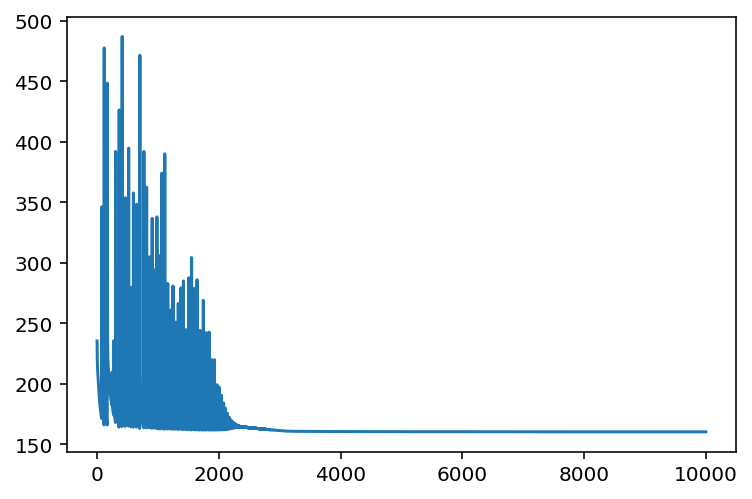

160.24736


In [9]:
fig, ax = plt.subplots()
ax.plot(loss_sgd)
plt.show()
print(loss_sgd[-1])

## RWMH

In [10]:
%%time
step_size = 1e-2
n_blind_steps = 10_000
key = jax.random.PRNGKey(0)
chain_rwmh, avg_accept_prob = rwmh_sampler(log_posterior_fn, params_sgd, key, n_samples, n_blind_steps, step_size)
print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

Avg. accept. prob.: 12.71%
CPU times: user 55.6 s, sys: 452 ms, total: 56.1 s
Wall time: 57.5 s


## HMC

In [11]:
%%time
hmc_step_size = 1e-3
n_leapfrog_steps = 5_000
key = jax.random.PRNGKey(0)
chain_hmc, avg_accept_prob = hmc_sampler(log_posterior_fn, params_sgd, key, n_samples, n_leapfrog_steps, hmc_step_size)
print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

Avg. accept. prob.: 88.35%
CPU times: user 1min 20s, sys: 457 ms, total: 1min 20s
Wall time: 1min 21s


## NUTS

In [12]:
%%time
max_depth = 12
print('max leapfrog steps: ', 2**max_depth)
key = jax.random.PRNGKey(0)
chain_nuts, ratio_valid_samples, total_stops = nuts_sampler(log_posterior_fn, params_sgd, key, n_samples, max_depth, hmc_step_size)
print(f'Proportion valid: {ratio_valid_samples.mean():.2%}')
print(f'Termination: max_steps={total_stops[0]}, u-turn={total_stops[1]}, max_error={total_stops[2]}.')

max leapfrog steps:  4096
Proportion valid: 96.44%
Termination: max_steps=2000, u-turn=0, max_error=0.
CPU times: user 1min 16s, sys: 257 ms, total: 1min 17s
Wall time: 1min 17s


## ensamble

In [13]:
%%time
ens_size = 10
key = jax.random.PRNGKey(0)
chain_ens = init_sd*jax.random.normal(key, [ens_size, n_params])
chain_ens, loss_history = train_ensamble(log_posterior_fn, chain_ens, n_epochs, lr_start, lr_stop)

CPU times: user 1.14 s, sys: 29.8 ms, total: 1.17 s
Wall time: 1.22 s


## create dict. of chains

In [14]:
chains_dict = {
    'sgd': chain_sgd,
    'ensamble': chain_ens,
    'rwmh': chain_rwmh,
    'hmc': chain_hmc,
    'nuts': chain_nuts,
}

# predictions

## overlaid

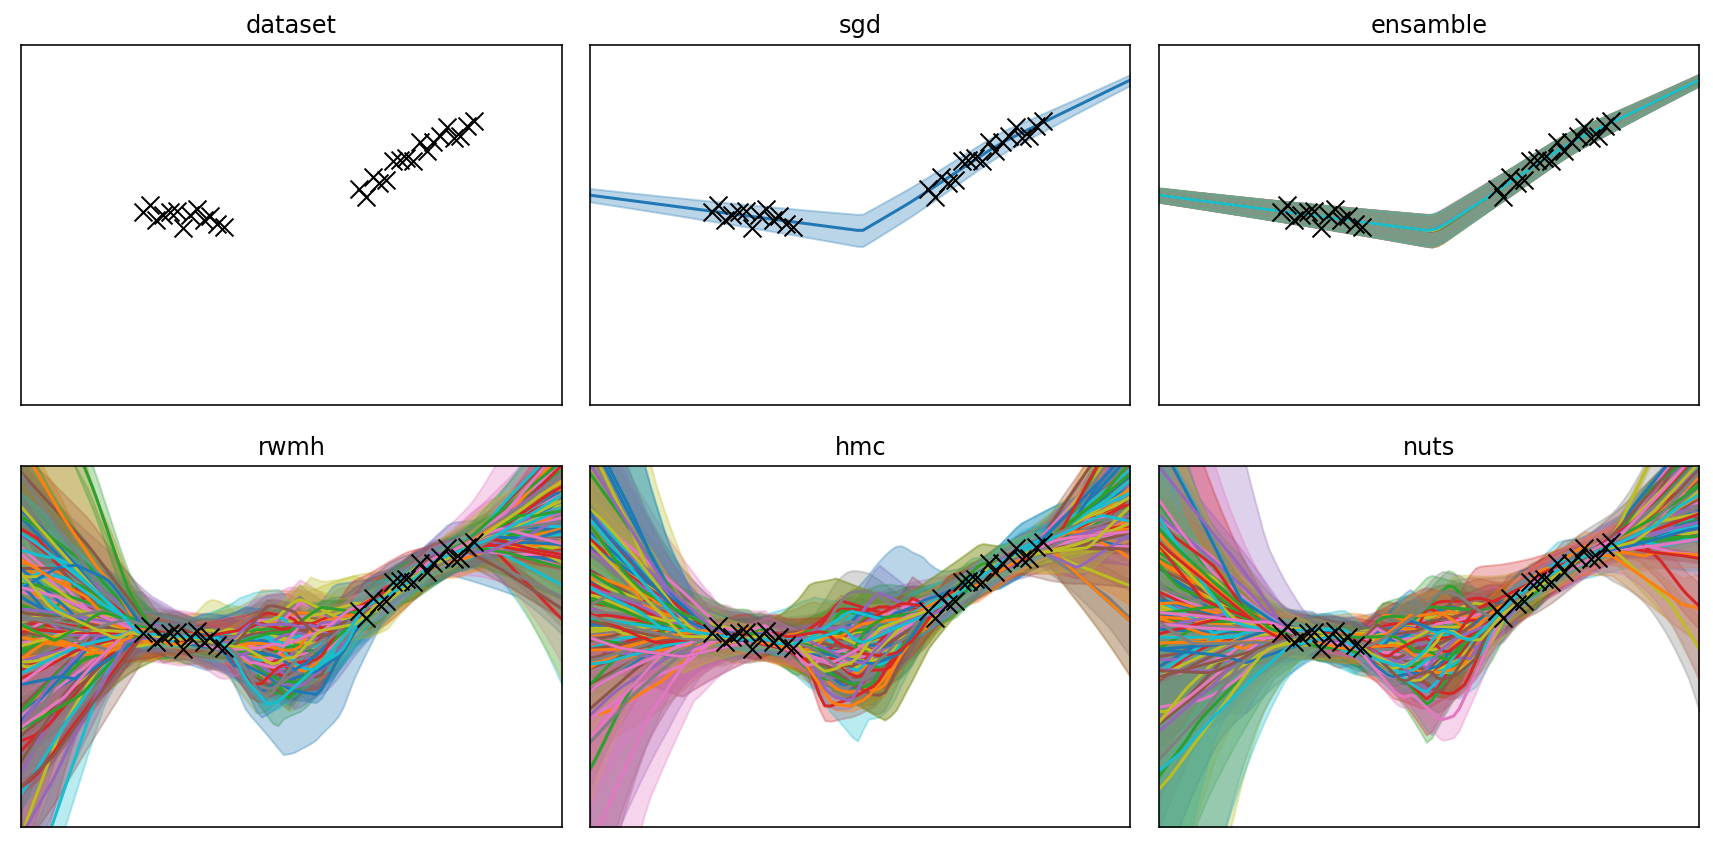

In [15]:
fig, axs = plt.subplots(2, 3, figsize=[12, 6])
axs = axs.flatten()

x_full = jnp.linspace(-2, 2, 100)[:, None]
names = ['dataset', 'sgd', 'ensamble', 'rwmh', 'hmc', 'nuts']
for i, name in enumerate(names):
    if name != 'dataset':
        chain = chains_dict[name]
        for j, params in enumerate(chain[:100]):
            y_hat = predict_fn(x_full, params)
            axs[i].fill_between(x_full[:, 0], y_hat[:, 0]-2*y_hat[:, 1], y_hat[:, 0]+2*y_hat[:, 1], alpha=0.3, color=f'C{j}')
            axs[i].plot(x_full[:, 0], y_hat[:, 0], color=f'C{j}')
        
    axs[i].scatter(x_train[:, 0], y_train, marker='x', c='black', s=80, linewidth=1, zorder=10)
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-3, 3])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(name)

plt.tight_layout()
plt.savefig('plots/1d_predictions_overlaid.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## PDF

In [16]:
def get_pdf(chain):
    # create grid to evaluate posterior predictive density
    nx, ny = 800, 400
    x_full = jnp.linspace(-2, 2, nx)
    y_full = jnp.linspace(-4, 4, ny)

    def get_posterior_density(params):
        y_hat = predict_fn(x_full[:, None], params)
        mean, std = y_hat[:, 0], y_hat[:, 1]
        log_prob = distributions.gaussian_log_pdf(y_full[None, :], mean[:, None], std[:, None])
        log_prob = jnp.nan_to_num(log_prob)
        return log_prob

    density_fn_vmap = jax.vmap(get_posterior_density)
    z_full = density_fn_vmap(chain)

    # average over posterior samples
    # - p(y) = sum (p(y|theta_i) * p(theta_i)) = (sum p(y|theta_i)) / n
    # - p(y) = (sum exp logp(y|theta_i)) / n
    # - logp(y) = log((sum exp logp(y|theta_i)) / n)
    # - logp(y) = (log-sum-exp logp(y|theta_i)) - log(n)
    log_z_full = jax.scipy.special.logsumexp(z_full, 0) - jnp.log(len(chain))
    z_full = jnp.exp(log_z_full)

    return x_full, y_full, z_full

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=[13, 6])
axs = axs.flatten()

names = ['dataset', 'sgd', 'ensamble', 'rwmh', 'hmc', 'nuts']
for i, name in enumerate(names):
    if name != 'dataset':
        chain = chains_dict[name]
        x_full, y_full, z_full = get_pdf(chain)
        extent = [x_full[0], x_full[-1], y_full[0], y_full[-1]]
        axs[i].imshow(z_full.T**(1/4), origin='lower', cmap='magma', extent=extent, aspect=0.3)
        axs[i].axis('off')
    else:
        axs[i].set_xlim([-2, 2])
        axs[i].set_ylim([-4, 4])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        
    axs[i].scatter(x_train[:, 0], y_train, marker='x', color='black', s=80, linewidth=1)
    axs[i].set_title(name)
    

plt.tight_layout()
plt.savefig('plots/1d_predictions_pdf.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## confidence interval

In [22]:
def get_quantiles(key, x, chain, n_samples=10_000):
    n_samples_per_step = n_samples // len(chain)
    
    samples = jnp.zeros([nx, len(chain), n_samples_per_step])
    for i, params in enumerate(chain):
        key, _ = jax.random.split(key)
        y_hat = predict_fn(x_full[:, None], params)
        mean = y_hat[:, 0]
        std = y_hat[:, 1]
        current_samples = mean[:, None] + std[:, None] * jax.random.normal(key, [nx, n_samples_per_step])
        samples = samples.at[:, i, :].set(current_samples)

    # flatten sampled predictions across posterior samples
    samples = samples.reshape([nx, -1])

    # get posterior predictive quntiles (alpha/2, 0/5, alpha)
    quantiles = jnp.quantile(samples, jnp.array([alpha/2, 0.5, 1-alpha/2]), axis=1)
    return quantiles

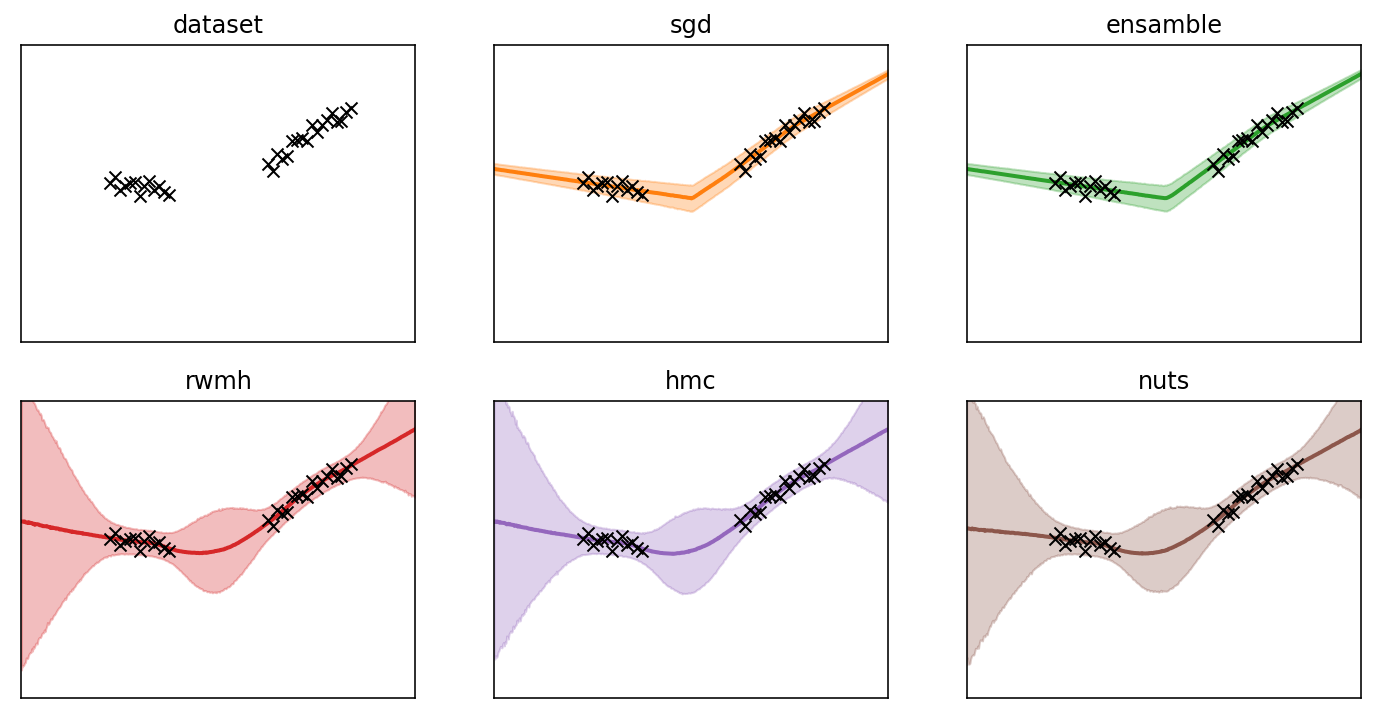

In [23]:
fig, axs = plt.subplots(2, 3, figsize=[12, 6])
axs = axs.flatten()
key = jax.random.PRNGKey(0)
alpha = 0.05
nx = 500
x_full = jnp.linspace(-2, 2, nx)


names = ['dataset', 'sgd', 'ensamble', 'rwmh', 'hmc', 'nuts']
for i, name in enumerate(names):
    if name != 'dataset':
        chain = chains_dict[name]
        quantiles = get_quantiles(key, x_full, chain)
        axs[i].fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3, color=f'C{i}')
        axs[i].plot(x_full, quantiles[1, :], lw=2, color=f'C{i}')
    axs[i].scatter(x_train[:, 0], y_train, marker='x', color='black', linewidth=1, zorder=5)
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-3, 3])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(name)

plt.savefig('plots/1d_predictions_ci.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## varying prior scale

In [24]:
prior_sd_list = [0.1, 0.2, 0.5, 1, 3, 10]
step_size = 1e-4
n_samples_sd = 500
chains_by_prior = {}
for sd in prior_sd_list:
    log_prior_fn = distributions.make_gaussian_log_prior(sd)
    log_posterior_fn = distributions.make_log_posterior_fn(x_train, y_train, log_likelihood_fn, log_prior_fn)
    chain, avg_accept_prob = hmc_sampler(log_posterior_fn, params_sgd, key, n_samples_sd, n_leapfrog_steps, step_size)
    print(f'Prior: {sd}, accept. prob.: {avg_accept_prob.mean():.2%}')
    chains_by_prior[sd] = chain

Prior: 0.1, accept. prob.: 99.98%
Prior: 0.2, accept. prob.: 99.94%
Prior: 0.5, accept. prob.: 99.76%
Prior: 1, accept. prob.: 99.63%
Prior: 3, accept. prob.: 99.08%
Prior: 10, accept. prob.: 88.85%


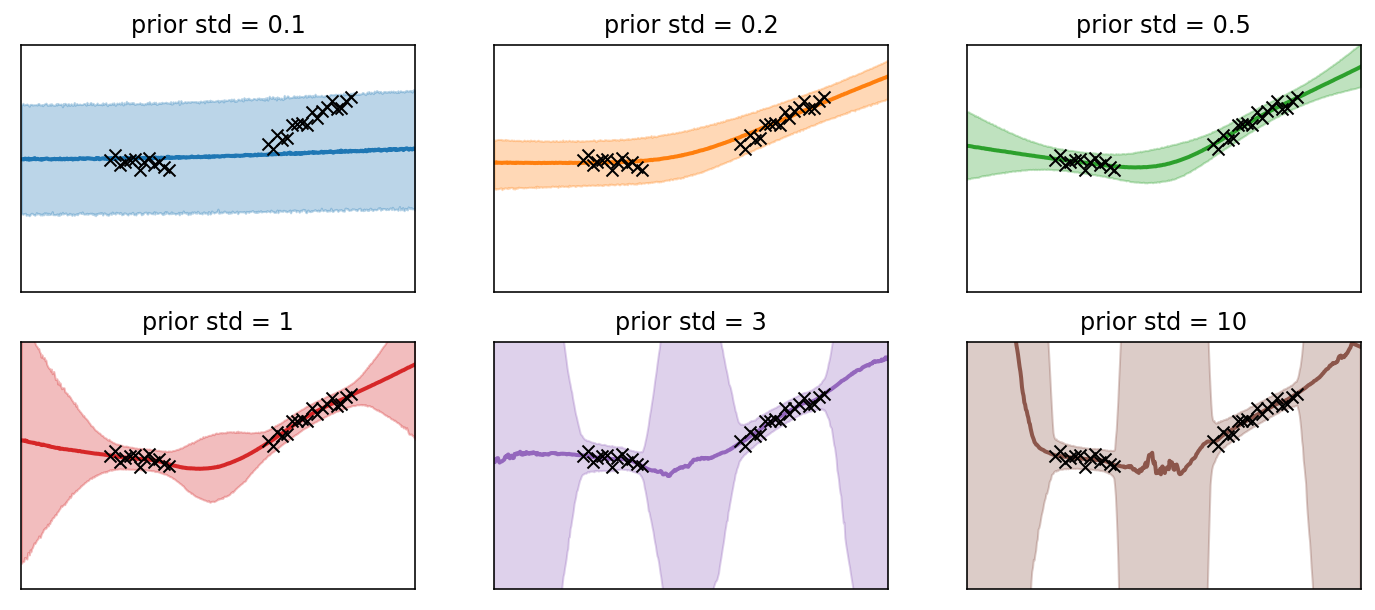

In [25]:
fig, axs = plt.subplots(2, 3, figsize=[12, 5])
axs = axs.flatten()
key = jax.random.PRNGKey(0)
alpha = 0.05
nx = 500
x_full = jnp.linspace(-2, 2, nx)


for i, (sd, chain) in enumerate(chains_by_prior.items()):
    quantiles = get_quantiles(key, x_full, chain)
    axs[i].fill_between(x_full, quantiles[0, :], quantiles[2, :], alpha=0.3, color=f'C{i}')
    axs[i].plot(x_full, quantiles[1, :], lw=2, color=f'C{i}')
    axs[i].scatter(x_train[:, 0], y_train, marker='x', color='black', linewidth=1, zorder=5)
    axs[i].set_xlim([-2, 2])
    axs[i].set_ylim([-3, 3])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f'prior std = {sd}')

plt.savefig('plots/1d_predictions_by_stdev.pdf', bbox_inches='tight', pad_inches=0)
plt.show()